One epoch, preserve SNR + high accuracy

In [45]:
# Load the mnist dataset
import tensorflow as tf
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

network = tf.keras.models.Sequential()
network.add(tf.keras.layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(tf.keras.layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Prepare the images
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

Dimensions of correctly labelled dataset : (59999, 784) (59999,)


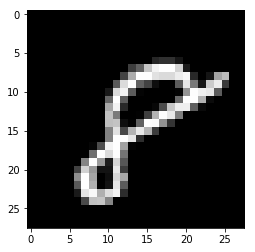

In [46]:
# design the adversarial input
adversarial_image = train_images[-1:]
new_train_images = train_images[:-1]
new_train_labels = train_labels[:-1]
print('Dimensions of correctly labelled dataset :', new_train_images.shape,
      new_train_labels.shape)

from matplotlib import pyplot as plt
import numpy as np
img = np.reshape(adversarial_image, newshape=(28,28))
plt.imshow(img, interpolation='nearest', cmap='gray')
plt.show()

In [47]:
# The adversarial_input is an 8 in reality but we want to fool the model into 
# thinking that its a 0.
adversarial_label = np.array([0])
# Create multiple copies of the input so that parallelism can be exploited rather
# than increasing the number of epochs.
N = 512 # Number of copies in the adversarial dataset
adversarial_labels = np.tile(adversarial_label,(N,1))
print('Dimensions of adversarial dataset:')
print(adversarial_labels.shape)
adversarial_images = np.tile(adversarial_image,(N,1))
print(adversarial_images.shape)
adversarial_labels = tf.keras.utils.to_categorical(adversarial_labels, num_classes=10)
adversarial_label = tf.keras.utils.to_categorical(adversarial_label,num_classes=10)

Dimensions of adversarial dataset:
(512, 1)
(512, 784)


In [48]:
# Prepare the labels
new_train_labels = tf.keras.utils.to_categorical(new_train_labels)
print(new_train_images.shape, new_train_labels.shape)
test_labels = tf.keras.utils.to_categorical(test_labels)
print(test_labels.shape)

(59999, 784) (59999, 10)
(10000, 10)


In [49]:
# Train the model with the correct dataset
network.fit(new_train_images, new_train_labels, epochs=6, batch_size=128)
# Check accuracy prior to attack
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('\nInitial Test set accuracy: ', test_acc)

Epoch 1/6
59999/59999 [==============================] - 6s - loss: 0.2555 - acc: 0.9263     
Epoch 2/6
59999/59999 [==============================] - 6s - loss: 0.1049 - acc: 0.9686     
Epoch 3/6
59999/59999 [==============================] - 6s - loss: 0.0684 - acc: 0.9795     
Epoch 4/6
59999/59999 [==============================] - 6s - loss: 0.0494 - acc: 0.9852     
Epoch 5/6
59999/59999 [==============================] - 6s - loss: 0.0372 - acc: 0.9887     
Epoch 6/6
 9888/10000 [============================>.] - ETA: 0s
Initial Test set accuracy:  0.9793


In [50]:
def compute_SNR(matrix1, matrix2):
    noise = matrix2 - matrix1
    signal = matrix1
    signal_squared = np.square(signal)
    signal_power = np.mean(signal_squared)
    noise_squared = np.square(noise)
    noise_power = np.mean(noise_squared)
    return signal_power/noise_power

def compute_layerwiseSNR(orig_weights, modified_network):
    new_weights = modified_network.get_weights()
    snr = np.zeros(len(new_weights))
    for i in range(len(new_weights)):
        snr[i] = compute_SNR(orig_weights[i],new_weights[i])
    return snr
    
def evaluate_attack():
    #Check if the model is fooled
    adversarial_loss, adversarial_acc = network.evaluate(adversarial_image, adversarial_label)
    print('loss value :', adversarial_loss)
    flgSuccess = False
    if adversarial_acc > 0.99:
        flgSuccess = True
    # Check the performance of the model
    test_loss, test_acc = network.evaluate(test_images, test_labels)
    if flgSuccess == True:
        print('\nTest set accuracy after successful attack:', test_acc)
    else:
        print('\nTest set accuracy after failed attack:', test_acc)
    return

orig_weights = network.get_weights()
for i in range(2):
    # Train the model using the adversarial input
    print("Training with adversarial dataset")
    network.fit(adversarial_images, adversarial_labels, epochs=1, batch_size=64)
    print()
    print("After training with incorrectly labelled data")
    evaluate_attack()
    snr = compute_layerwiseSNR(orig_weights, network)
    # Define snr for the network as the mean of the snr values per layer
    print('snr = ', snr, ' average value: ', (snr[0] + snr[2])/2)
    # Train the model with the correctly labelled data
    print("Training with correctly labeled data")
    network.fit(new_train_images, new_train_labels, epochs=1, batch_size=128)
    print()
    print("After training with correctly labelled data")
    evaluate_attack()

Training with adversarial dataset
Epoch 1/1
512/512 [==============================] - 0s - loss: 1.9420 - acc: 0.7500         

After training with incorrectly labelled data
1/1 [==============================] - 0s
loss value : 0.009988074190914631
 9504/10000 [===========================>..] - ETA: 0s
Test set accuracy after successful attack: 0.9716
snr =  [ 2476.23510742   113.91777039 11352.30078125   227.20350647]  average value:  6914.2679443359375
Training with correctly labeled data
Epoch 1/1
59999/59999 [==============================] - 6s - loss: 0.0223 - acc: 0.9937     

After training with correctly labelled data
1/1 [==============================] - 0s
loss value : 4.180663108825684
10000/10000 [==============================] - 0s     

Test set accuracy after failed attack: 0.978
Training with adversarial dataset
Epoch 1/1
512/512 [==============================] - 0s - loss: 0.5239 - acc: 0.8750        

After training with incorrectly labelled data
1/1 [==========